# part0: imports

In [1]:
%matplotlib inline


import os, pathlib
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    # %run "S7-dim.ipynb"

    print('Done')

FIGPATH = params.figPath / 'figS4-techniques'
if not os.path.exists(FIGPATH):
    os.makedirs(FIGPATH)

Done


### get data

In [2]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [3]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [4]:
full_list_MCx, allDFs_MCx = get_full_monkey_data()
allDFs_M1, allDFs_Str = get_full_mouse_data()


Executed: `get_full_monkey_data` in 13.2s
Executed: `get_full_mouse_data` in 0.7s


### Fig S4A: VAF vs 


In [5]:
from scipy.linalg import inv
try:
    matlab.engine
    print('Matlab engine already running!')
except NameError:
    import matlab.engine
    eng = matlab.engine.start_matlab()
dpcaPath = str(params.repoPath) + '/tools/dPCA/'
eng.cd(dpcaPath, nargout=0)
        
def vaf_pca_cca(df1:pd.DataFrame, field1: str, epoch1,
               df2:pd.DataFrame, field2: str, epoch2,
               n_components:int =10) -> (np.ndarray, np.ndarray):
    """
    Measure vaf for each CCA axis, between 2 DataFrames, fields, time epochs.
    epoch1, epoch2: an instance of the `pyal.generate_epoch_fun` function.
    """
 
    df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
    rates_1 = np.concatenate(df1[field1].values, axis=0)
    rates_1_model = PCA(n_components=n_components, svd_solver='full').fit(rates_1)
    rates_1_C = rates_1_model.components_
    df1 = pyal.apply_dim_reduce_model(df1, rates_1_model, field1, '_pca');
    pca_1_data = np.concatenate(df1['_pca'].values, axis=0)

    
    df2 = pyal.restrict_to_interval(df2, epoch_fun=epoch2)
    rates_2 = np.concatenate(df2[field2].values, axis=0)
    rates_2_model = PCA(n_components=n_components, svd_solver='full').fit(rates_2)
    rates_2_C = rates_2_model.components_
    df2 = pyal.apply_dim_reduce_model(df2, rates_2_model, field2, '_pca');
    pca_2_data = np.concatenate(df2['_pca'].values, axis=0)
    
    
    # same number of timepoints in both matrices
    n_samples = min ([pca_1_data.shape[0], pca_2_data.shape[0]])
    pca_1_data = pca_1_data[:n_samples,:]
    pca_2_data = pca_2_data[:n_samples,:]

    A, B, *_ = dt.canoncorr(pca_1_data, pca_2_data, fullReturn=True)
    vafs_cc1 = np.array(vaf_cc(rates_1, rates_1_C, A))[0]/100
    vafs_cc2 = np.array(vaf_cc(rates_2, rates_2_C, B))[0]/100

    vafs_pc1 = np.cumsum(rates_1_model.explained_variance_ratio_)
    vafs_pc2 = np.cumsum(rates_2_model.explained_variance_ratio_)
    
    return vafs_cc1, vafs_cc2, vafs_pc1, vafs_pc2

def vaf_cc(X, C, A):
    W = C.T@A #neural -> CCs
    V = W@inv(A.T@A) #neural -> CCs 
    vaf = eng.dpca_explainedVariance(X.T, W, V)['cumulativeDPCA']
    return vaf

@utility.report
def plot_monkey_vaf_cca(ax, full_list_MCx, allDFs_MCx, top_n: int=10):
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    
    field = monkey_defs.areas[2]+'_rates'
    vafs_cc1 = []
    vafs_cc2 = []
    vafs_pc1 = []
    vafs_pc2 = []
    vafs = []
    for df1,df2 in zip(side1df,side2df):
        vafs_cc1_, vafs_cc2_, vafs_pc1_, vafs_pc2_ = vaf_pca_cca(
            df1, field, monkey_defs.exec_epoch, 
            df2, field, monkey_defs.exec_epoch)

        # vafs_cc1.append(np.array(vafs_cc1_)[0])
        # vafs_cc2.append(np.array(vafs_cc2_)[0])
        # vafs_pc1.append(np.array(vafs_pc1_)[0])
        # vafs_pc2.append(np.array(vafs_pc2_)[0])

        vafs_cc1.append(vafs_cc1_[top_n-1])
        vafs_cc2.append(vafs_cc2_[top_n-1])
        vafs_pc1.append(vafs_pc1_[top_n-1])
        vafs_pc2.append(vafs_pc2_[top_n-1])

        vafs.append(np.mean([vafs_cc1_, vafs_cc2_], axis = 0).flatten())

    vafs_cc1 = np.array(vafs_cc1)
    vafs_cc2 = np.array(vafs_cc2)
    vafs_pc1 = np.array(vafs_pc1)
    vafs_pc2 = np.array(vafs_pc2)

    ax.scatter(vafs_cc1, vafs_pc1, c = 'k')
    ax.scatter(vafs_cc2, vafs_pc2, c = 'k')
    ax.set_xlabel("VAF CCs")
    ax.set_ylabel("VAF PCs")
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    # vafs = np.array(vafs).T
    # print(vafs.shape)
    # x_ = np.arange(1,monkey_defs.n_components+1)
    # for vaf in vafs.T:
    #     # ax.plot(x_, vafs1[i], color='grey', alpha = 0.3)
    #     # ax.plot(x_, vafs2[i], color='grey', alpha = 0.3)
    #     ax.plot(x_, vaf, color = 'grey', alpha = 0.3)
    # utility.shaded_errorbar(ax, x_, vafs, color='k', marker = 'o')

    # ax.set_xlabel("Neural mode")
    # ax.set_ylabel('VAF (\%)')

    return vafs
        

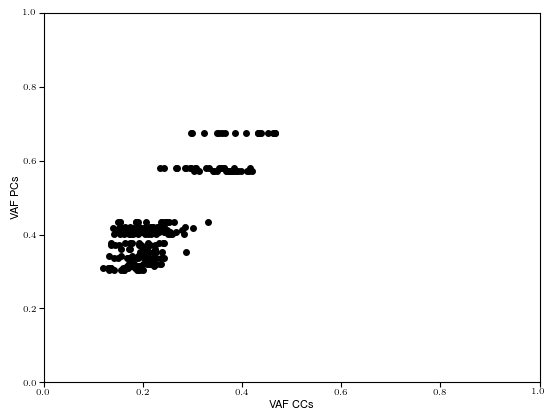

In [6]:
fig,ax = plt.subplots(dpi=100)
vafs = plot_monkey_vaf_cca(ax,full_list_MCx, allDFs_MCx, top_n=4)
plt.savefig(FIGPATH / 'vaf_cca_monkeys.pdf', format= 'pdf')
clear_output()


### Fig S4B: CCA based on manifold dimensionality

In [7]:
@utility.report
def plot_monkey_cca_dim(ax, full_list_MCx, allDFs_MCx):
    dim_range = range(2,20)

    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    
    allCCs=np.empty((len(side1df), len(list(dim_range)))) * np.nan
    for i, n_comp in enumerate(dim_range):
        AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch,
                                     area=monkey_defs.areas[2], model=n_comp)
        AllData2 = dt.get_data_array(side2df, monkey_defs.exec_epoch,
                                     area=monkey_defs.areas[2], model=n_comp)
        _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
        CCs= []
        for sessionData1, sessionData2 in zip(AllData1, AllData2):
            data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_comp))
            data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_comp))
            CCs.append(dt.canoncorr(data1, data2)[:4].mean())
        allCCs [:,i]=CCs 

    # plotting
    x_ = list(dim_range)
    utility.shaded_errorbar(ax, x_, allCCs.T, color=params.colors.MonkeyPts, marker = 'o', label='Monkeys')

    ax.set_ylim([-.05,1])
    ax.set_xlim([x_[0]-.4,x_[-1]+.4])
    ax.set_xlabel('Number of included neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Average top 4 \ncanonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([x_[0], x_[-1]])
    ax.spines['left'].set_bounds([0,1])
    return allCCs

@utility.report
def plot_monkey_cca_dim_prep(ax, full_list_MCx, allDFs_MCx):
    dim_range = range(2,20)

    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            if 'J' in animal1 or 'J' in animal2: continue
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    
    allCCs=np.empty((len(side1df), len(list(dim_range)))) * np.nan
    for i, n_comp in enumerate(dim_range):
        AllData1 = dt.get_data_array(side1df, monkey_defs.prep_epoch,
                                     area=monkey_defs.areas[2], model=n_comp)
        AllData2 = dt.get_data_array(side2df, monkey_defs.prep_epoch,
                                     area=monkey_defs.areas[2], model=n_comp)
        _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
        CCs= []
        for sessionData1, sessionData2 in zip(AllData1, AllData2):
            data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_comp))
            data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_comp))
            CCs.append(dt.canoncorr(data1, data2)[:4].mean())
        allCCs [:,i]=CCs 

    # plotting
    x_ = list(dim_range)
    utility.shaded_errorbar(ax, x_, allCCs.T, color='tab:green', marker = 'o', label='Monkeys (prep)')

    ax.set_ylim([-.05,1])
    ax.set_xlim([x_[0]-.4,x_[-1]+.4])
    ax.set_xlabel('Number of included neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Average top 4 \ncanonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([x_[0], x_[-1]])
    ax.spines['left'].set_bounds([0,1])
    return allCCs



In [8]:
@utility.report
def plot_mouse_cca_dim(ax, allDFs_M1, area = 'M1'):
    dim_range = range(2,20)

    defs = mouse_defs
    
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]

    allCCs=np.empty((len(side1df), len(list(dim_range)))) * np.nan
    for i, n_comp in enumerate(dim_range):
        AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=area, model=n_comp)
        AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=area, model=n_comp)
        _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape), axis=0)
        CCs=[]
        for sessionData1,sessionData2 in zip(AllData1, AllData2):
                data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_comp))
                data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_comp))
                CCs.append(dt.canoncorr(data1, data2)[:4].mean())
        allCCs[:,i] = CCs


    #====================================PLOTTING
    
    x_ = list(dim_range)
    c = params.colors.MouseM1 if 'M' in area else params.colors.MouseStr
    utility.shaded_errorbar(ax, x_, allCCs.T, color=c, marker = 'o', label=f'Mouse {area}')

    ax.set_ylim([-.05,1])
    ax.set_xlim([x_[0]-.4,x_[-1]+.4])
    ax.set_xlabel('Number of included neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Average top 4 \ncanonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([x_[0], x_[-1]])
    ax.spines['left'].set_bounds([0,1])
    return allCCs

@utility.report
def plot_mouse_cca_dim_prep(ax, allDFs_M1, area = 'M1'):
    dim_range = range(2,20)

    defs = mouse_defs
    
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]

    allCCs=np.empty((len(side1df), len(list(dim_range)))) * np.nan
    for i, n_comp in enumerate(dim_range):
        AllData1 = dt.get_data_array(side1df, defs.prep_epoch, area=area, model=n_comp)
        AllData2 = dt.get_data_array(side2df, defs.prep_epoch, area=area, model=n_comp)
        _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape), axis=0)
        CCs=[]
        for sessionData1,sessionData2 in zip(AllData1, AllData2):
                data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_comp))
                data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_comp))
                CCs.append(dt.canoncorr(data1, data2)[:4].mean())
        allCCs[:,i] = CCs


    #====================================PLOTTING
    
    x_ = list(dim_range)
    c = params.colors.MouseM1 if 'M' in area else params.colors.MouseStr
    utility.shaded_errorbar(ax, x_, allCCs.T, color=c, marker = 'o', label=f'Mouse {area}')

    ax.set_ylim([-.05,1])
    ax.set_xlim([x_[0]-.4,x_[-1]+.4])
    ax.set_xlabel('Number of included neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Average top 4 \ncanonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([x_[0], x_[-1]])
    ax.spines['left'].set_bounds([0,1])
    return allCCs



In [9]:
fig=plt.figure(dpi=100)
gs = fig.add_gridspec(nrows=1, ncols=1, wspace=0)
ax = fig.add_subplot(gs[0])

allDFs_M1, allDFs_Str = get_full_mouse_data()

plot_monkey_cca_dim(ax, full_list_MCx, allDFs_MCx)
plot_monkey_cca_dim_prep(ax, full_list_MCx, allDFs_MCx)
plot_mouse_cca_dim(ax, allDFs_M1)
plot_mouse_cca_dim(ax, allDFs_Str, 'Str')
ax.legend()

plt.savefig(FIGPATH / 'CCA-dim.pdf', format= 'pdf')
clear_output()

Executed: `get_full_mouse_data` in 0.9s


/home/jcc319/multi_animal_alignment/tools/dataTools.py:496: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
/home/jcc319/multi_animal_alignment/tools/dataTools.py:496: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
/home/jcc319/multi_animal_alignment/tools/dataTools.py:496: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
/home/jcc319/multi_animal_alignment/tools/dataTools.py:496: UserWarning: Dropping the trials with the following 

Executed: `plot_monkey_cca_dim` in 2617.9s


### Fig S4C: Procrustes

#### Align all sessions

In [ ]:
defs = monkey_defs
pairFileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        pairFileList1.append((I,J))
print(f'{len(pairFileList1)=}')

side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
side2df = [allDFs_MCx[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

warnings.filterwarnings("default")

#align all data
allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allCCs0.append(dt.procrustes_wrapper(data1, data2))
allCCs0 = np.array(allCCs0).T


#### Lower bound

In [ ]:
single_FileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        single_FileList1.append((I,J))

n_iter = params.n_iter

#MCx
side1df = [allDFs_MCx[i] for i,_ in single_FileList1]
side2df = [allDFs_MCx[j] for _,j in single_FileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.prep_epoch, area=defs.areas[2], model=defs.n_components)
AllData1_ = dt.get_data_array(side2df, defs.fixation_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)

warnings.filterwarnings("default")

inCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData1_):
    r = []
    for n in range(n_iter):
        sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
        sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

        data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        r.append(dt.procrustes_wrapper(data1, data2))
    inCCs0.append(r)
inCCs0 = np.array(inCCs0)
CC_lower_bound_MCx = np.percentile(inCCs0, 1, axis=1).T


#### Upper bound

In [ ]:
single_FileList1 = []
for I, _ in enumerate(full_list_MCx):
    single_FileList1.append(I)


warnings.filterwarnings("ignore")
side1df = [allDFs_MCx[i] for i in single_FileList1]
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)

warnings.filterwarnings("default")

n_iter = params.n_iter

n_shared_trial1 = AllData1.shape[2]
trialList1 = np.arange(n_shared_trial1)


CCs1=[]
for session, sessionData in enumerate(AllData1):
    r = []
    for n in range(n_iter):
        params.rng.shuffle(trialList1)
        # non-overlapping randomised trials
        trial1 = trialList1[:n_shared_trial1//2]
        trial2 = trialList1[-(n_shared_trial1//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
        r.append(dt.procrustes_wrapper(data1, data2))
    CCs1.append(r)
CCs1 = np.array(CCs1)
CC_upper_bound_MCx = np.percentile(CCs1, 99, axis=1).T

#### Plot Procrustes correlations

In [ ]:
plt.close('all')
set_rc()
fig=plt.figure()
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

ax = fig.add_subplot(gs[0])
ax_hist = fig.add_subplot(gs[1])


utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), allCCs0, color='b', marker = 'o', label=f'Across, $n={allCCs0.shape[1]}$')

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), CC_upper_bound_MCx, color='cornflowerblue', marker = '<', ls='--', label=f'Within, $n={CC_upper_bound_MCx.shape[1]}$')

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), CC_lower_bound_MCx, color='gray', marker = '>', ls=':', label=f'Control, $n={CC_lower_bound_MCx.shape[1]}$')

ax.set_ylim([0,1])
ax.set_xlim([.5,defs.n_components+.5])
ax.set_xlabel('Neural mode')
ax.set_title(f'{defs.areas[2]} Alignment')
ax.set_ylabel('Procructes correlation')


#plot the hist

bins = np.arange(0,1,0.05)
ax_hist.xaxis.set_visible(False)
ax_hist.set_facecolor('None')
ax_hist.spines['bottom'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['left'].set_bounds([0,1])
ax_hist.set_ylim([-.05,1])
ax_hist.hist(allCCs0[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across ($n={allCCs0.shape[1]}$)',
        color=params.colors.MainCC, alpha=.8, orientation='horizontal')
ax_hist.hist(CC_upper_bound_MCx[:4,:].mean(axis=0), bins=bins, density=True,label=f'Within ($n={CC_upper_bound_MCx.shape[1]}$)',
        color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
ax_hist.hist(CC_lower_bound_MCx[:4,:].mean(axis=0), bins=bins, density=True, label=f'Control ($n={CC_lower_bound_MCx.shape[1]}$)',
        color=params.colors.LowerCC, alpha=.8, orientation='horizontal')

ax_hist.tick_params('y', direction='out')
ax_hist.set_yticklabels([])
ax_hist.legend(loc=(0,-.05))


fig.savefig(FIGPATH / 'monkey-procrustes-modes.pdf', format='pdf', bbox_inches='tight')

### Fig S4D: Procrustes vs CCA

In [ ]:
pairFileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        pairFileList1.append((I,J))
print(f'{len(pairFileList1)=}')

side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
side2df = [allDFs_MCx[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

warnings.filterwarnings("default")

allPro=[]
allCC=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allPro.append(dt.procrustes_wrapper(data1, data2))
    allCC.append(dt.canoncorr(data1, data2))
allCC = np.array(allCC).T
allPro = np.array(allPro).T

# plot
fig, ax = plt.subplots(1, 1, dpi=200)

ax.scatter(allCC[:4,:].mean(axis=0), allPro[:4,:].mean(axis=0))
ax.axline([0, 0], [1, 1], color='r')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(min(xlim[0],ylim[0]), max(xlim[1], ylim[1]))
ax.set_ylim(min(xlim[0],ylim[0]), max(xlim[1], ylim[1]))
ax.set_aspect('equal')

ax.set_xlabel('CCA')
ax.set_ylabel('Procrustes')
ax.set_title('Average top 4 modes')
# ax.ticklabel_format(style='scientific', scilimits=(6,6), useMathText=True)

fig.savefig(FIGPATH / 'procrustes-CCA.pdf', format='pdf', bbox_inches='tight')